# Flatiron Phase 4 Project

## Aaron Galbraith

### Submitted: October 10, 2023

## Contents

- **[Business Understanding](#Business-Understanding)<br>**
- **[Data Understanding](#Data-Understanding)**<br>
- **[Data Preparation](#Data-Preparation)**<br>
- **[Exploration](#Exploration)**<br>
- **[Modeling](#Modeling)**<br>
- **[Evaluation](#Evaluation)**<br>
- **[Recommendations](#RECOMMENDATIONS)<br>**

# Business Understanding

Apple launched the iPad 2 on March 11, 2011, the same day that the 2011 SXSW Festival began in Austin, TX. Apple also launched a pop-up store in Austin specifically to sell these and other products to the swell of crowds who attended the festival that year.\* Apple product launches for their lines of iPods, iPhones, and iPads were a very big deal at the time, and much media coverage was devoted to the frenzy that accompanied each launch, e.g. Apple customers eagerly waiting in long lines for the newest product on the first day it was available for sale.

Apple can simply look to its accounting to see how successful its sales were in Austin during SXSW. But there is more to be learned than just how many dollars it made in the short term. By heavily promoting its product launches in an environment such as this festival, Apple encourages its customers (and loyal fans, and potential customers, and even detractors) to join in a conversation about them. This creates a great opportunity for Apple to get candid feedback on a massive scale about what it's doing that excites people as well as what disappoints people. This feedback can obviously inform future choices Apple makes in developing and launching its products.

Following the festival, Apple wished to gain insight into how its presence at the festival had been received. Tweets with the hashtag #sxsw were collected and labeled according to 1) what sentiment if any they expressed and 2) which if any tech brands or products (limited to Apple and Google) were mentioned. Apple wanted to know what it could learn not only from its own festival presence but also from Google's presence at the same festival.

<sub><sup>\*Essentially none of this information accompanied the dataset. Every single tweet contained the hashtag #sxsw, and a frequency analysis of the tweets indicated they took place in 2011. Further research yielded websites such as https://techcrunch.com/2011/03/10/ipad-2-sxsw/ and https://googleblog.blogspot.com/2011/03/google-at-sxsw-2011-austin-here-we-come.html, which provided helpful details about the activities of Apple and Google at the 2011 SXSW Festival.</sup></sub>

# Data Understanding

## Import files

Here we'll import all the tools we'll need.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize
from operator import itemgetter
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from nltk import TweetTokenizer
import string
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, roc_curve
from unidecode import unidecode
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import imblearn.pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier

SEED = 19

## Load and briefly explore data set

In [2]:
# read csv into dataframe
df = pd.read_csv('../data/tweets.csv', encoding='latin-1')
# show overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
# show row and column counts
df.shape

(9093, 3)

In [4]:
# show how many unique values for each feature
df.nunique()

tweet_text                                            9065
emotion_in_tweet_is_directed_at                          9
is_there_an_emotion_directed_at_a_brand_or_product       4
dtype: int64

From the above we see that there are evidently some duplicated tweets; there are 4 different "emotion" labels; and there are 9 different product or brand labels.

In [5]:
# show value counts for one feature
df.emotion_in_tweet_is_directed_at.value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

Apple products seem to be mentioned more than Google products.

In [6]:
# show normalized value counts for one feature
round(df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True),2)

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    0.59
Positive emotion                      0.33
Negative emotion                      0.06
I can't tell                          0.02
Name: proportion, dtype: float64

There are very few negative emotions expressed. The majority are neutral

In [7]:
# show breakdown of sentiment labels for tweets that have no product or brand identified
round(df[df.emotion_in_tweet_is_directed_at.isna()] \
.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True),2)

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    0.91
Positive emotion                      0.05
I can't tell                          0.03
Negative emotion                      0.01
Name: proportion, dtype: float64

For tweets not associated with a brand, most are labeled neutral, but a few are not.

In [8]:
# show examples of tweets that DO express emotion but are NOT directed at a specific product
df[(df.is_there_an_emotion_directed_at_a_brand_or_product != 'No emotion toward brand or product') &
   (df.emotion_in_tweet_is_directed_at.isna())
  ].tweet_text

46      Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...
64      Again? RT @mention Line at the Apple store is ...
68      Boooo! RT @mention Flipboard is developing an ...
90      Thanks to @mention for publishing the news of ...
102     ÛÏ@mention &quot;Apple has opened a pop-up st...
                              ...                        
9043    Hey is anyone doing #sxsw signing up for the g...
9049    @mention you can buy my used iPad and I'll pic...
9052    @mention You could buy a new iPad 2 tmrw at th...
9054    Guys, if you ever plan on attending #SXSW, you...
9058    &quot;Do you know what Apple is really good at...
Name: tweet_text, Length: 504, dtype: object

Clearly some/most of the tweets we can see here *are* associated with brands.

## Summary of data

There are 9,093 records and three features. As there are only 9,065 unique tweets, it appears that there are some duplicates.

A little more than one third (3,291) of the tweets are identified as being directed at a particular product or brand associated with either Google or Apple, while the majority do not identify a product or brand.

Relatively few records have been identified as having a negative or "I can't tell" emotion.

For the 5,802 records that don't identify a product or brand, about 9% of them were identified as having something other than "no emotion". Upon investigation of these, it appears that some of them mention "Apple" or "iPad" after all, so evidently some tweets have not been successfully associated with a product or brand.

# Data Preparation

## Renaming features

The column names are a bit cumbersome, so we'll give them new names that are easier to deal with.

In [9]:
# rename columns
df.rename(columns={'tweet_text': 'text',
                   'emotion_in_tweet_is_directed_at': 'brand',
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'},
          inplace = True)

## Missing values

In [10]:
# show records with missing text
df[df.text.isna()]

,text,brand,sentiment
6,NaN,NaN,No emotion toward brand or product


We can't do anything with a record whose text is missing, so we'll drop it.

In [11]:
# drop records with missing text values
df.dropna(subset=['text'], inplace=True)

## Edit values

As these tasks may increase the number of duplicate records, we should perform them before we look for those duplicates.

### Lower case

It's not likely that we'll lose anything important by shifting all the text to lower case, especially given the nature of tweeting.

In [12]:
# shift all text to lower case
df['text'] = df['text'].str.lower()

### Rename and merge sentiments

The sentiment labels could be more succinct. We'll change them.

Also, since there were so few "unknown" sentiments, we'll just group those together with "neutral" sentiments.

In [13]:
sentiment_rename = {
    "No emotion toward brand or product": "neutral",
    "Positive emotion": "positive",
    "Negative emotion": "negative",
    "I can't tell": "neutral"
}

df.sentiment = df.sentiment.apply(lambda x: sentiment_rename[x])

### Merge brand labels

In [14]:
# show breakdown of brand before merging
df.brand.value_counts()

brand
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [15]:
# assign either apple or google label and fill in missing values with other
df['brand'].replace(['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'], 'apple',
                     inplace=True)
df['brand'].replace(['Google', 'Other Google product or service', 'Android App', 'Android'], 'google',
                     inplace=True)
df['brand'].fillna('other',
                    inplace=True)

In [16]:
# show breakdown of brand after merging
df.brand.value_counts()

brand
other     5801
apple     2409
google     882
Name: count, dtype: int64

## Detect missing brand labels

As noted earlier, we suspect many of the tweets labeled "other" actually refer to a certain product or brand. We'll use some helpful keywords to reclassify some of the tweets that are not yet associated with either brand.

In the event that some tweets happen to mention both brands, we'll make a label for "both", and we'll label everything else "neither".

In [17]:
# make key word lists for apple and google
apple_words = ['ipad', 'apple', 'iphone', 'itunes', 'ipad2']
google_words = ['google', 'android', 'blogger', 'marissa', 'mayer', 'sketchup', 'h4ckers', 'youtube', 'circles']
# add hashtags
apple_hash = []
for word in apple_words:
    apple_hash.append('#'+word)
apple_words.extend(apple_hash)
google_hash = []
for word in google_words:
    google_hash.append('#'+word)
google_words.extend(google_hash)
# consolidate all terms in one list
brand_words = apple_words + google_words

In [18]:
# make a function that relabels brand values by finding what keywords are mentioned in the text
def brand_fix(text, brand):
    # only relabel records that do not have one of the two brands already associated
    if brand != 'other':
        return brand
    else:
        apple, google = False, False
        # look for apple keyword
        for word in apple_words:
            if word in text:
                apple = True
                break
        # look for google keyword
        for word in google_words:
            if word in text:
                google = True
                break

        # return correct new label
        if apple & ~google:
            return 'apple'
        elif google & ~apple:
            return 'google'
        elif apple & google:
            return 'both'
        else:
            return 'neither'

In [19]:
# run above function to relabel brand values
df['brand'] = df.apply(lambda x: brand_fix(x.text, x.brand), axis=1)
# show breakdown of brand after running function
df.brand.value_counts()

brand
apple      5394
google     2845
neither     663
both        190
Name: count, dtype: int64

In [102]:
df[df.brand == 'apple'].sentiment.value_counts(normalize=True)

sentiment
neutral     0.528418
positive    0.394502
negative    0.077080
Name: proportion, dtype: float64

In [103]:
df[df.brand == 'google'].sentiment.value_counts(normalize=True)

sentiment
neutral     0.654905
positive    0.291814
negative    0.053282
Name: proportion, dtype: float64

We were able to label a vast majority of the unassociated tweets with a brand that the tweet mentions.

## Duplicates

Now we'll address duplicated tweets

In [20]:
# show how many records are duplicates
df.duplicated().value_counts()

False    9050
True       42
Name: count, dtype: int64

Let's see if there is a difference if we only select for duplicated text (not product or sentiment).

In [21]:
# show how many records are duplicates for the text value only
df.duplicated(subset=['text']).value_counts()

False    9047
True       45
Name: count, dtype: int64

It looks like 3 text records are duplicated with either different sentiments or different associated brands. Let's look at what sentiment labels these were given, as separate groups.

In [22]:
# show sentiment identification for groups of duplicated tweets
for i, index in enumerate(df.drop_duplicates()[df.duplicated(subset=['text'])].index):
    print(
        'duplicate group', i+1, '\n',
        df.loc[index].text, '\n\n',
        df[df.text == df.loc[index].text].sentiment.value_counts(),
        '\n\n- - - -\n'
    )

duplicate group 1 
 win free ipad 2 from webdoc.com #sxsw rt 

 sentiment
neutral     4
positive    2
Name: count, dtype: int64 

- - - -

duplicate group 2 
 rt @mention marissa mayer: google will connect the digital &amp; physical worlds through mobile - {link} #sxsw 

 sentiment
neutral     5
positive    4
Name: count, dtype: int64 

- - - -

duplicate group 3 
 rt @mention rt @mention it's not a rumor: apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {link} 

 sentiment
neutral     2
positive    1
Name: count, dtype: int64 

- - - -



<ipython-input-22-7c19d15d088f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i, index in enumerate(df.drop_duplicates()[df.duplicated(subset=['text'])].index):


In [23]:
# show some of the duplicated tweets
df[df.duplicated()].text.head(25)

467        before it even begins, apple wins #sxsw {link}
468        before it even begins, apple wins #sxsw {link}
664     if you're in a room full of people w/good wi-f...
775     google to launch major new social network call...
776     google to launch major new social network call...
798     google to launch major new social network call...
2231    marissa mayer: google will connect the digital...
2232    marissa mayer: google will connect the digital...
2559    counting down the days to #sxsw plus strong ca...
3810             win free ipad 2 from webdoc.com #sxsw rt
3811             win free ipad 2 from webdoc.com #sxsw rt
3812             win free ipad 2 from webdoc.com #sxsw rt
3814             win free ipad 2 from webdoc.com #sxsw rt
3950    really enjoying the changes in gowalla 3.0 for...
3962    #sxsw is just starting, #ctia is around the co...
4897    oh. my. god. the #sxsw app for ipad is pure, u...
4954               40% of google maps use is mobile #sxsw
5338    rt @me

It's a tough call what to do with these duplicates. Some of them, like the first one, could be multiple people sharing the same article, and it could be meaningful to count all such instances, as they represent *more* of that sentiment. Some others, however, like the "win free ipad 2", appear to be from a business promoting itself. In that case, we wouldn't want to skew our results by counting all such instances.

In any event, due to the nature of tweeting, it is certainly plausible that these duplicated tweets were not erroneously duplicated, but rather they were actually separate, if identical, tweets when they were posted.

Several duplicates we see here start with "rt". We know that "rt" means "retweet", which specifically is a way for Twitter users to amplify a tweet they agree with.

Let's compromise on the duplicates by keeping all retweets but dropping the other duplicates.

In [24]:
# combine ALL retweets with NON-DUPLICATED other tweets
df = pd.concat([
    # retweets
    df[df.text.str.startswith('rt')],
    # non-retweets, minus duplicates
    df[~df.text.str.startswith('rt')].drop_duplicates()
# reset the index
]).reset_index()
# drop newly created index column
df.drop(columns='index', inplace=True)

In [25]:
# show row and column counts
df.shape

(9071, 3)

## Begin NLP

Now that we have the data set we want to work with, we'll use natural language processing techniques to help us analyze it.

First we'll create a list of all the tweets. As we tokenize and lemmatize, etc, we can always come back to this for the full context.

In [26]:
# make list of all tweet texts
tweets = df.text.to_list()

Then we'll create a list of all the tokens. To do this, we'll use a tokenizer that is specifically designed to parse tweets from Twitter and a lemmatizer.

In [27]:
# make tokenizer
tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True
)

# create list of tokens from data set
tokens = tokenizer.tokenize(','.join(tweets))

# remove hashtags and accents
tokens = [unidecode(word) for word in tokens if not word.startswith('#')] + \
[unidecode(word[1:]) for word in tokens if word.startswith('#')]

We'll take this opportunity while lemmatizing to get rid of hashtags.

In [28]:
# make lemmatizer
lemmatizer = WordNetLemmatizer()

# lemmatize the list of words
tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]

Let's look at the most frequently occurring tokens.

In [29]:
# show the most frequently occurring tokens
FreqDist(tokens_lemmatized).most_common(25)

[(',', 12561),
 ('sxsw', 9573),
 ('.', 5890),
 ('the', 4423),
 ('link', 4314),
 ('}', 4288),
 ('{', 4285),
 ('to', 3580),
 ('at', 3097),
 ('rt', 2952),
 ('ipad', 2670),
 ('a', 2567),
 ('for', 2544),
 ('google', 2451),
 ('!', 2368),
 ('apple', 2223),
 ('in', 1936),
 (':', 1830),
 ('of', 1711),
 ('is', 1705),
 ('"', 1696),
 ('and', 1635),
 ('?', 1611),
 ('iphone', 1573),
 ('store', 1518)]

This list is utterly dominated by stopwords. In addition to punctuation characters, some twitter-specific terms appear here, as well as some ordinary stopwords, and of course sxsw. Let's start a stopwords list and put it to use.

In [30]:
# obtain the standard list of stopwords
nltk.download('stopwords', quiet=True)
# start our own list of stopwords with these words
stop_list = stopwords.words('english')
# add to this list some twitter-specific terms
stop_list.extend(['sxsw', 'link', 'rt'])
# add punctuation characters
for char in string.punctuation:
    stop_list.append(char)
# add empty string
stop_list.extend(['', 'ha', 'wa'])

In [31]:
# make stopped list of tokens
tokens_stopped = [word for word in tokens_lemmatized if word not in stop_list]

In [32]:
# show the most frequently occurring tokens
FreqDist(tokens_stopped).most_common(25)

[('ipad', 2670),
 ('google', 2451),
 ('apple', 2223),
 ('iphone', 1573),
 ('store', 1518),
 ('2', 1370),
 ('new', 1087),
 ('austin', 956),
 ('app', 819),
 ('launch', 688),
 ('circle', 685),
 ('social', 644),
 ('...', 639),
 ('android', 588),
 ('today', 571),
 ('network', 471),
 ('get', 453),
 ('line', 442),
 ('via', 435),
 ('u', 434),
 ('pop-up', 422),
 ('party', 401),
 ('free', 383),
 ('called', 358),
 ('mobile', 343)]

This looks much better.

It seems quite probable that the "2" here is often occurring when tweets include a space in the expression "ipad 2". Let's look at them in context to see if we're right.

First we'll write a function to pull some random tweets that feature a given term or phrase.

In [33]:
# a function that displays several randomly chosen tweets that include a given term or phrase
def tweet_samples(term, count=5):
    relevant_tweets = [tweet for tweet in tweets if term in tweet]
    if len(relevant_tweets) > 0:
        count = min(count, len(relevant_tweets))
        random_tweets = np.random.choice(relevant_tweets, count)
        for tweet in random_tweets:
            print(tweet)
    else:
        print('No tweets contain this phrase.')

In [34]:
tweet_samples('2', count=5)

details for the ipad 2 giveaway coming tonight, rt this! #sxsw #sxswi
the apple store in austin and 100 people taking a pic of it. #ipad2 #sxsw {link}
#sxsw 2011 trends:
out: google
in: twitter
next: angry birds
@mention i was there ~5:30 and the line was around the block. decided to forgo ipad 2 goodness for food. #sxsw #apple
uber brand smart: gonna move a ton of ipad2 - #apple opening a popup shop in austin for #sxsw  {link} via@mention @mention


Indeed, it looks like a lot of those 2s are really part of iPad 2.

Let's write a quick function to join those words together in future lemmatization.

In [35]:
def ipad_fix(word_list):
    new_word_list = []
    for i in range(len(word_list)):
        if i < len(word_list) - 1 and word_list[i] == 'ipad' and word_list[i+1] == '2':
            new_word_list.append('ipad2')
        elif i > 0 and word_list[i-1] == 'ipad' and word_list[i] == '2':
            continue
        else:
            new_word_list.append(word_list[i])
    return new_word_list

In [36]:
tokens_stopped = ipad_fix(tokens_stopped)

In [37]:
# show the most frequently occurring tokens
FreqDist(tokens_stopped).most_common(25)

[('google', 2451),
 ('apple', 2223),
 ('iphone', 1573),
 ('ipad', 1541),
 ('store', 1518),
 ('ipad2', 1423),
 ('new', 1087),
 ('austin', 956),
 ('app', 819),
 ('launch', 688),
 ('circle', 685),
 ('social', 644),
 ('...', 639),
 ('android', 588),
 ('today', 571),
 ('network', 471),
 ('get', 453),
 ('line', 442),
 ('via', 435),
 ('u', 434),
 ('pop-up', 422),
 ('party', 401),
 ('free', 383),
 ('called', 358),
 ('mobile', 343)]

By the way, we can use term frequency to try to figure out what year all of this took place. We'll start around the year the first iPhone was released (2007) and include the year the dataset was created (2013).

In [38]:
# iterate over a likely timespan
for year in range(2007,2014):
    # show how frequently a given year was mentioned
    print(str(year)+':', FreqDist(tokens_stopped)[str(year)])

2007: 0
2008: 0
2009: 1
2010: 4
2011: 75
2012: 0
2013: 0


This is how we deduced that the data comes from 2011 (which allowed us to learn more context for the SXSW conference in Austin, TX from that particular year).

# Exploration

## Overview

Let's compare the brand and sentiment distributions of the tweets.

/Users/stubbletrouble/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


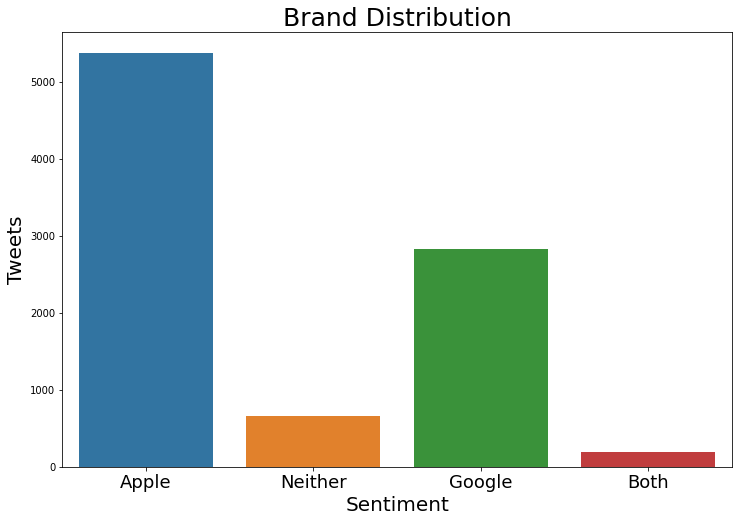

In [39]:
labels = ['Apple','Neither','Google', 'Both']
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(df['brand'])
plt.title('Brand Distribution', fontsize=25)
# ax.set_yticklabels([0,500,1000,1500,2000,2500,3000,3500], fontsize=18)
ax.set_xticklabels(labels, fontsize=18)
plt.xlabel('Sentiment',fontsize=20)
plt.ylabel('Tweets',fontsize=20)
# plt.legend(loc=1, prop={'size': 15})
plt.show()

We've associated the vast majority of the tweets with Apple or Google (or both).

/Users/stubbletrouble/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


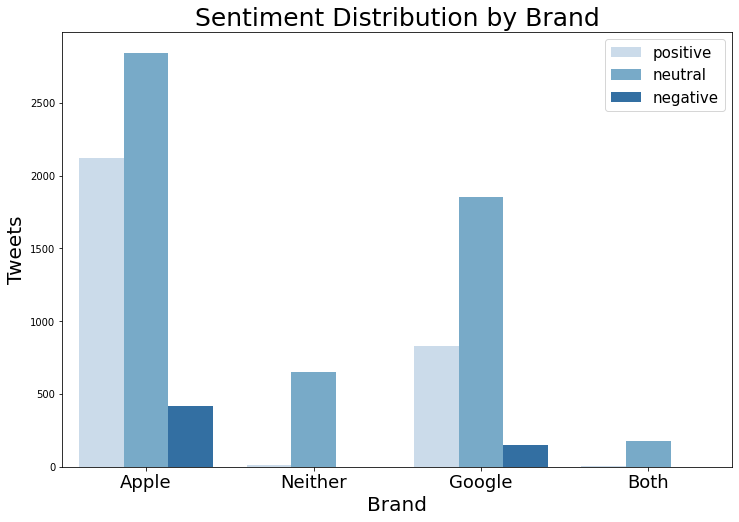

In [40]:
labels = ['Apple','Neither','Google', 'Both']
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(df['brand'], hue=df['sentiment'], palette='Blues')
plt.title('Sentiment Distribution by Brand', fontsize=25)
# ax.set_yticklabels([0,500,1000,1500,2000,2500], fontsize=18)
ax.set_xticklabels(labels, fontsize=18)
plt.xlabel('Brand',fontsize=20)
plt.ylabel('Tweets',fontsize=20)
plt.legend(loc=1, prop={'size': 15})
plt.show()

Tweets that mentioned both or neither brand almost exclusively lacked an identifiable sentiment. These will only factor into some parts of our analysis.

Apple and Google had a similar distribution of positive, neutral and negative tweets. This will create some class imbalance issues during modeling.

## Word clouds

We'll be making several word clouds, so let's create a function that streamlines creating and plotting them.

In [41]:
# a function that generates a word cloud of a given list of words
def make_wordcloud(wordlist, colormap='Greens', title=None):
    # instantiate wordcloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        colormap=colormap,
        collocations = True
    )
    return wordcloud.generate(','.join(wordlist))

def plot_wordcloud(wordcloud):
    # plot wordcloud
    plt.figure(figsize = (12, 15)) 
    plt.imshow(wordcloud) 
    plt.axis('off');

Let's look at a word cloud of all the stopped words.

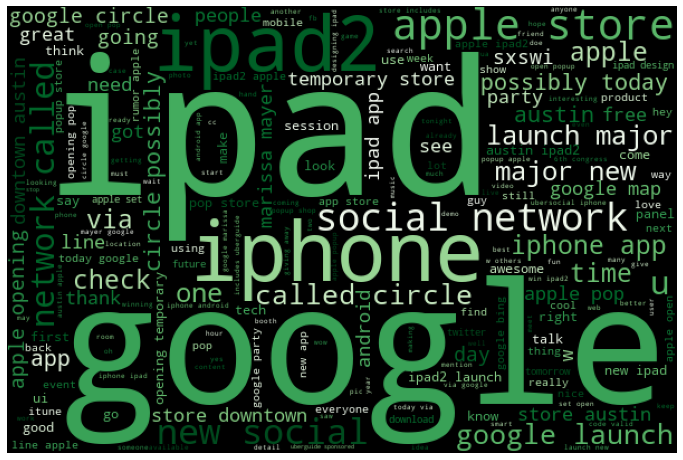

In [42]:
# word cloud of stopped words
plot_wordcloud(make_wordcloud(tokens_stopped))

This is as expected, but largely dominated by brand names. Let's try it again without any of the brand words.

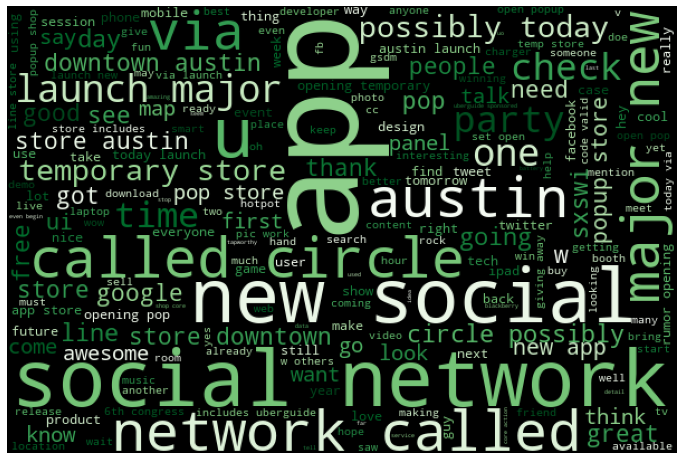

In [43]:
# word cloud of stopped words, omitting brand words
plot_wordcloud(make_wordcloud([word for word in tokens_stopped if word not in brand_words]))

This is not very illuminating just yet. We'll create some new word lists that focus just on the positives and negatives of each brand.

In [44]:
# a function that takes a list of tweets and 1) tokenizes them, 2) lemmatizes them, and 3) removes stopwords
def make_tokens(tweets):
    # make list of tokens
    tokens = tokenizer.tokenize(','.join(tweets))
    # lemmatize tokens
    tokens_lemmatized = [lemmatizer.lemmatize(word[1:]) for word in tokens if word.startswith('#')] + \
    [lemmatizer.lemmatize(word) for word in tokens if not word.startswith('#')]
    # stop tokens
    tokens_lemmatized = ipad_fix(tokens_lemmatized)
    tokens_stopped = [word for word in tokens_lemmatized if \
                      word not in stop_list and \
                      word not in brand_words]
    return tokens_stopped

In [45]:
# make tokens lists for all / positive / negative tweets, for both apple and google
tokens_apple_all = make_tokens(df[df.brand == 'apple'].text.to_list())
tokens_apple_pos = make_tokens(df[(df.brand == 'apple') & (df.sentiment == 'positive')].text.to_list())
tokens_apple_neg = make_tokens(df[(df.brand == 'apple') & (df.sentiment == 'negative')].text.to_list())
tokens_google_all = make_tokens(df[df.brand == 'google'].text.to_list())
tokens_google_pos = make_tokens(df[(df.brand == 'google') & (df.sentiment == 'positive')].text.to_list())
tokens_google_neg = make_tokens(df[(df.brand == 'google') & (df.sentiment == 'negative')].text.to_list())

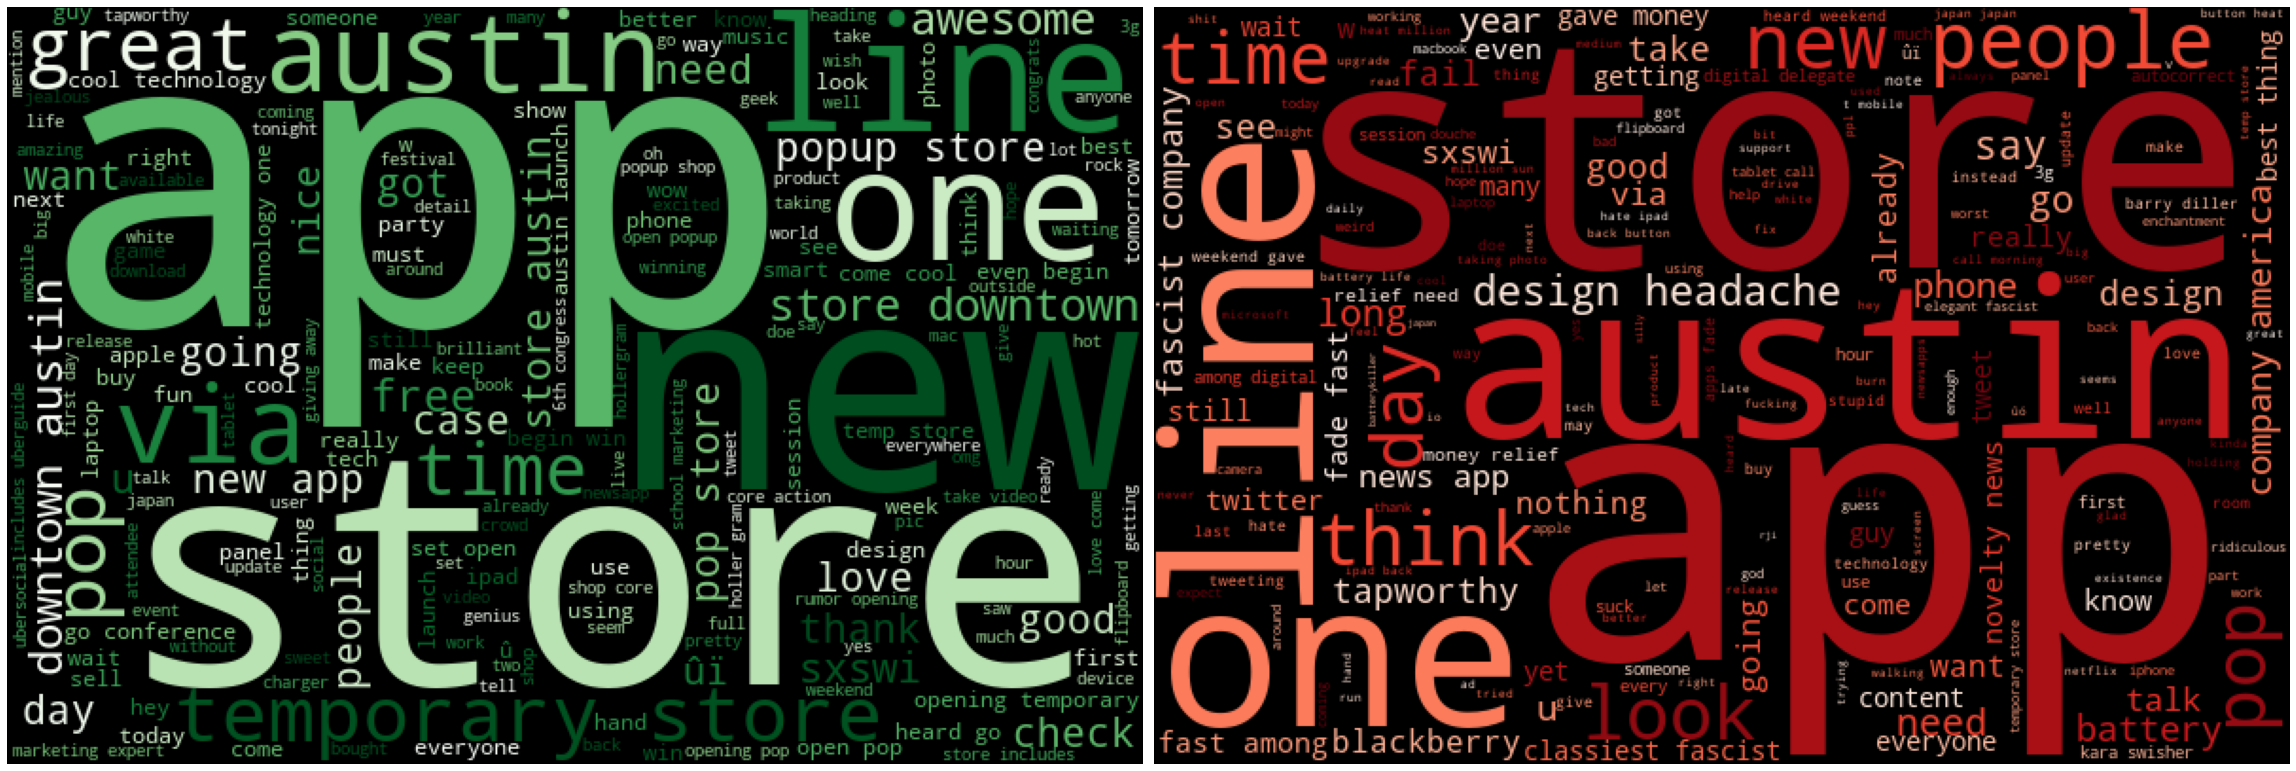

In [46]:
# show positive and negative wordclouds for apple side by side
fig, ax = plt.subplots(figsize=(32,24), ncols=2)
# plt.suptitle('Positive and Negative Word Clouds for Apple', fontsize=25)
ax[0].imshow(make_wordcloud(tokens_apple_pos))
ax[0].axis('off')
ax[1].imshow(make_wordcloud(tokens_apple_neg, colormap='Reds'))
ax[1].axis('off')
plt.tight_layout();

A lot of the positive buzz about Apple seems to be about the pop-up store in downtown Austin — terms like "temporary store", etc. There are even positive sentiments about the "line" there.

Some negative terms that stand out are "design headache" and "battery", as well as several phrases about a "fascist company" or an "elegant fascist". Also someone named "Kara Swisher" shows up.

Let's explore some context.

In [47]:
tweet_samples('temporary store')

rt @mention apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {link}
apple setting up temporary store in austin for #sxsw attendees to get their ipad2 fix: {link}
@mention rt @mention apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {link}
@mention @mention apple sets up temporary store at #sxsw; ipad anyone? {link} cc @mention
for those at #sxsw: apple sets up 5,000-square-foot temporary store at sxsw to sell new ipads, test potential traffic {link}


In [48]:
tweet_samples('line', count=10)

line at pop up apple store in austin. first person was here at 6 a.m.they have to wait until 5 p.m. #sxsw #ipad2  {link}
the line at the #sxsw apple popup store was shorter than the line at the starbucks across the street. so, i really had no choiceû_
inevitable huge lines for ipads at austin apple store #sxsw {link}
@mention ipad #apple #fanboy line at #sxsw on 6th &amp; congress drinking @mention wearing @mention &amp; @mention #corporatewhore #dmad #what
#sxsw day 5 at the #apple store and there's still a line...and growing {link}
awesome conversations and networking while on line at #sxsw apple store.
#ipad therefore i am.  what is the line like at the #apple store near #sxsw in austin?  send pics!
wow. i'm not spending a minute more at #sxsw in line than i have to. rt @mention apple popup store at #sxsw {link}
@mention the geeks need somewhere downtown to line up to get the ipad 2. i'll be dropping by. #sxsw
line of ppl around the block. #sxsw party? no, apple store! insane!  {li

In [49]:
tweet_samples('design headache')

headed for ipad design headaches (2 tablets, call in the morning) #sxsw {link}
kicking off ipad design headaches with josh clark (@mention very crowded room for first session - standing room only #sxsw
checking out ipad design headaches (2 tablets, call in the morning).
{link} #sxsw #tapworthy #fb
rt @mention slides from #sxsw talk, &quot;ipad design headaches &quot; {link} #tapworthy . really interesting for designers as well.
first up: ipad design headaches (2 tablets, call in the morning). #sxsw #tapworthy


In [50]:
tweet_samples('battery')

at midday, iphone at mid-battery. this outlet, blocked by an immobile booth, serves no purpose but to taunt me. #sxsw {link}
@mention glad i've not got a faulty iphone then. that'll go down well for #sxsw everyone's battery dies 5 times quicker. hope @mention knows.
my iphone battery can't keep up with my tweets! thanks apple.  #sxsw  #precommerce
has spontaniety in life been replaced by technology? when your iphone battery dies you go home. great ? at #busy #sxsw
my iphone battery at 100%. #winning at #sxsw


In [51]:
tweet_samples('kara swisher')

apple is the classiest facist company in america. - kara swisher #sxsw
rt @mention apple...&quot;the classiest fascist company in america&quot; kara swisher #sxsw
rt @mention &quot;apple: the most elegant fascist corporation in america today.&quot; -- kara swisher #sxsw #flipboard
ûïthe classiest fascist company in existenceû - kara swisher #sxsw #apple
apple...&quot;the classiest fascist company in america&quot; kara swisher #sxsw


### Summary of Apple's word clouds

A lot of people are talking about Apple's temporary pop-up store and reporting on the experience of waiting in line, not necessarily complaining about it.

Evidently Kara Swisher is a person who made a snarky comment about Apple being fascist.

# WRITE MORE HERE

Let's do the same for Google.

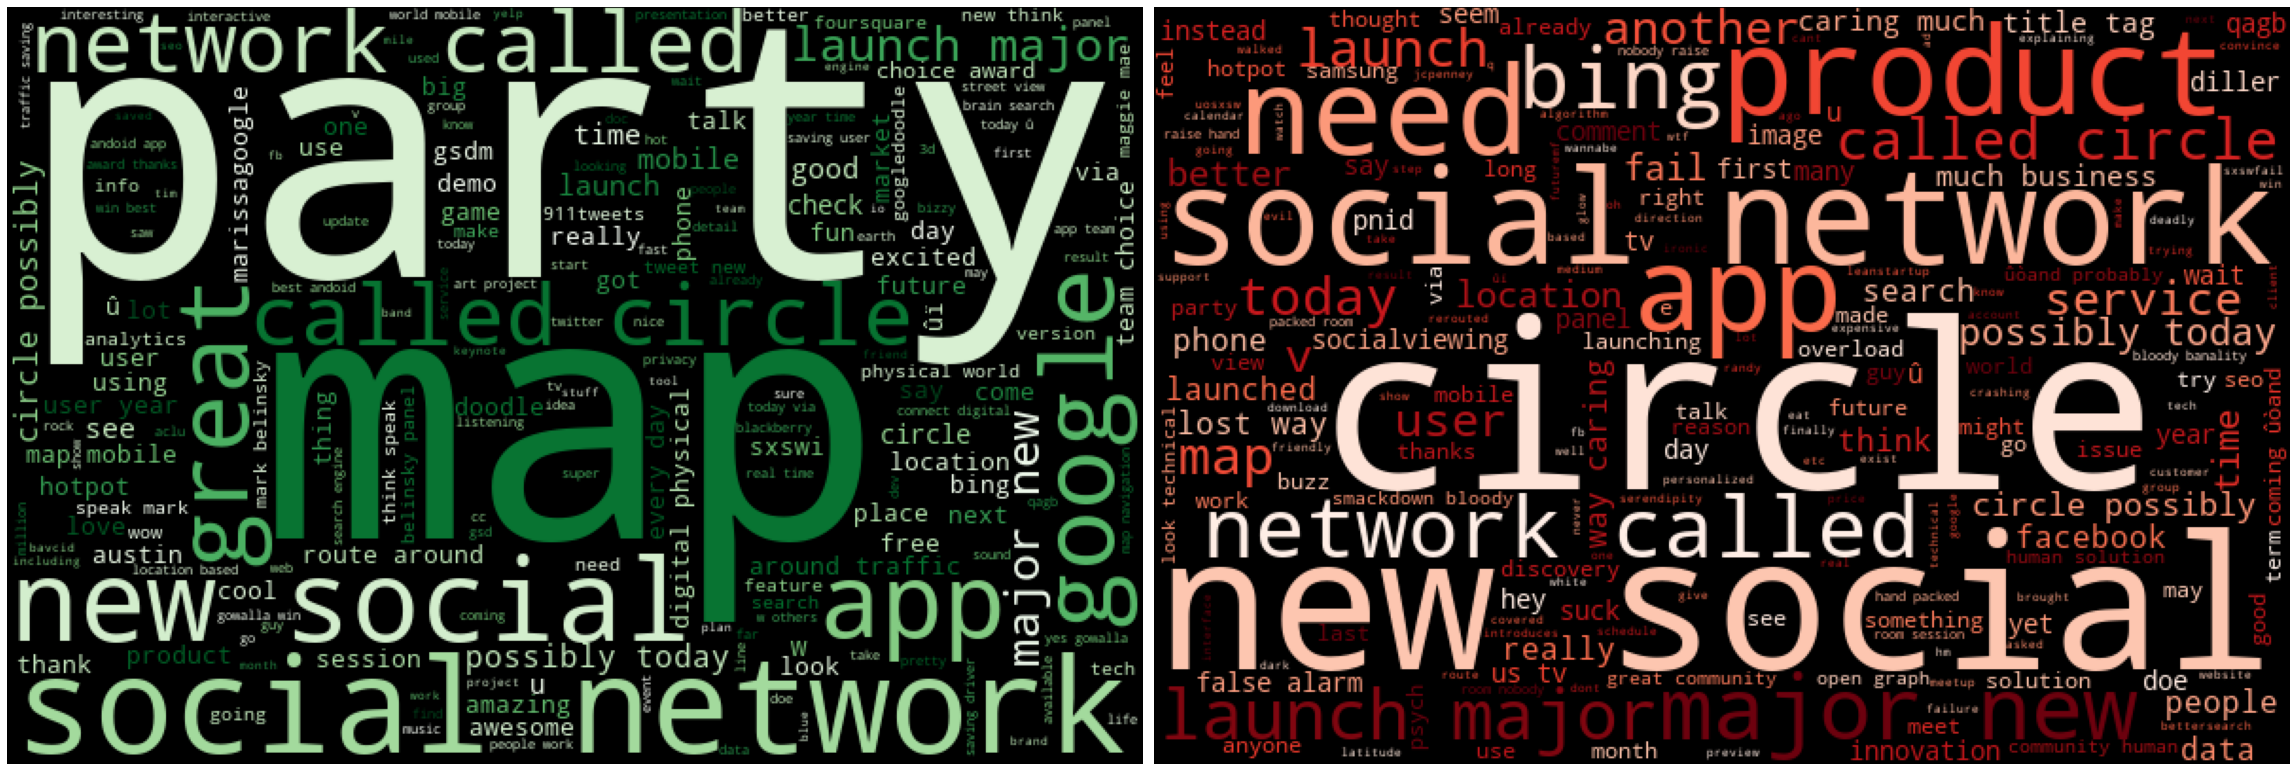

In [52]:
# show positive and negative wordclouds for google side by side
fig, ax = plt.subplots(figsize=(32,24), ncols=2)
ax[0].imshow(make_wordcloud(tokens_google_pos))
ax[0].axis('off')
ax[1].imshow(make_wordcloud(tokens_google_neg, colormap='Reds'))
ax[1].axis('off')
plt.tight_layout();

In [53]:
tweet_samples('party')

google's 1986 themed party at #sxsw  @mention maggie mae's {link}
smoked way too much yesterday! hahaha  #austin #wakenbake  painting at this android party tonight #sxsw #androidsxsw {link}
going to be awesome! rt @mention gallery of original daniel johnston art going up at tomorrow's #gsdm + #google industry party.  #sxsw
how you avoid long lines &amp; jam packed parties at #sxsw with #hurricane #party the new #iphone #app {link} #smm #geo #marketing
you should probably put that away... rt @mention at the android party and kinda embarrassed by my iphone #sxsw


In [54]:
tweet_samples('maps')

so cool: latest version of google maps mobile has 3d buildings. not sure if they've mapped aus to that detail yet ;-) #sxsw
google maps navigation + street view and 3d buildings is awesome #marissagoogle #sxsw
brought up how google maps had rerouted all images of jcpenney to images of macys or trashy restraunts. they had no comment #uosxsw #sxsw
marissa mayer: &quot;our focus is on location based services.&quot; demoed hotpot, google maps, vector maps, augmented reality. #sxsw #webvisions
rt @mention &quot;40% of all google maps usage is on mobile&quot; - marissa mayer #sxsw


In [55]:
tweet_samples('circles', count=10)

google  to launch major new social network called circles, possibly today {link} #sxsw
does anyone else at #sxsw know where #google is showing off circles today?
rt @mention #google could launch a 'major' new social network called circles, possibly today: {link} #sxsw remake of wave?
google to launch major new social network called circles: {link} possibly today #sxsw
google to launch major new social network called circles {link} #sxsw
rt @mention google to launch major new social network called circles, possibly today by @mention {link} via @mention #sxsw #22sxsw
rt @mention excited to know more about google circles. lucky folks at sxsw to be the first to see? possible launch today: {link} #sxsw
google to launch major new social network called circles (updated) {link} *not launched at #sxsw, but soon. should i care?
&quot;@mention google to launch major new social network called circles, possibly today {link}  #sxsw&quot; @mention
another one? holy social fragmentation&gt;google to l

In [56]:
tweet_samples('new social')

can't wait anymore!!! :)) &quot;google to launch major new social network called circles&quot; (via @mention {link} #google #circles #sxsw
rt @mention rumor at #sxsw that google will launch a new social network called &quot;circles&quot;. {link} @mention
very interesting --&gt;&gt; rt @mention google to launch major new social network called circles, possibly today {link} #sxsw
google to launch major new social network called circles!!!  #google #circles #sxsw {link}
rt @mention ûï@mention google to launch major new social network called circles, possibly today {link} #sxswû circles are 'closed' #weak


In [57]:
tweet_samples('bing')

great recap of a seemingly great #sxsw session: rt @mention relive the wonder that was the google v bing panel: {link}
google/bing search smackdown panel is in a giant room with not enough chairs. hope you have a search for &quot;floor-sitting!&quot; #sxsw
#sxsw 2011: the google and bing smackdown in all its bloody banality (guardian) {link} via @mention
any technologist who thinks &quot;search is history should see the 125 person line to get into &quot;google and bing speak on ranking&quot; at #sxsw
just in time @mention wrote an @mention article about us dubbing filmaster &quot;foursquare for cinemaphiles&quot; {link}  #sxsw


### Summary of Google's word clouds

# WRITE MORE HERE

# Modeling

Here we will classify only tweets that have positive or negative sentiments.

In [58]:
# make new dataframe with only positive or negative sentiments
df_posneg = df[(df.sentiment == 'positive') | (df.sentiment == 'negative')]
# convert sentiment to 0s and 1s
df_posneg.sentiment = df_posneg.sentiment.apply(lambda x: 1 if x == 'positive' else 0)

<ipython-input-58-366bf2f96125>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posneg.sentiment = df_posneg.sentiment.apply(lambda x: 1 if x == 'positive' else 0)


In [59]:
df_posneg.sentiment.value_counts()

sentiment
1    2969
0     569
Name: count, dtype: int64

In [60]:
df_posnon = df.copy()
# convert sentiment to 0s and 1s
# both 'negative' and 'neutral' will have zero values
df_posnon.sentiment = df_posnon.sentiment.apply(lambda x: 1 if x == 'positive' else 0)

In [61]:
df_posnon.sentiment.value_counts()

sentiment
0    6102
1    2969
Name: count, dtype: int64

## Tokenizer

We'll use what we developed during exploration to make a custom tokenizer function. This will perform all of the following:
- tokenize tweets
- remove accents and hashtags
- lemmatize tokens
- join "ipad" and "2" where appropriate

This tokenizer will *not* remove stopwords, as we may wish to vary our choice of stopwords in the models.

In [62]:
# make tokenizer
def custom_tokenize(document):
    # instantiate tokenizer
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True
    )

    # create list of tokens from data set
    tokens = tokenizer.tokenize(document)

    # remove hashtags and accents
    tokens = [unidecode(word) for word in tokens if not word.startswith('#')] + \
    [unidecode(word[1:]) for word in tokens if word.startswith('#')]
    
    # remove stop words
    tokens = [word for word in tokens if not word in stop_list]

    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # lemmatize the list of words
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]

    # perform ipad fix
    tokens_lemmatized = ipad_fix(tokens_lemmatized)
    
    return tokens_lemmatized

## Train and test sets

We'll split the data into train and test sets.

In [63]:
# split the data into target (sentiment) and predictor (text)
X, y = df_posnon['text'], df_posnon['sentiment']

# split the data into train and test sets
# set random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Plurality check

It will be instructive to recall the percentage of the plurality in the target feature (sentiment). Models should be evaluated in relation to this.

In [64]:
# save this value to compare to future model crossval scores
plurality_cv = round(y_train.value_counts(normalize=True)[1],4)
# show the sentiment breakdown
round(y_train.value_counts(normalize=True),4)

sentiment
0    0.6736
1    0.3264
Name: proportion, dtype: float64

In [65]:
y_pred_train = y_train.copy().apply(lambda x: 0)
train_acc = round(accuracy_score(y_pred_train, y_train),4)
y_pred_test = y_test.copy().apply(lambda x: 0)
test_acc = round(accuracy_score(y_pred_test, y_test),4)
print(
    'Plurality Calculation',
    '\n\nTraining Score: '+str(train_acc),
    '\nTest Score:     '+str(test_acc)
)

Plurality Calculation 

Training Score: 0.6736 
Test Score:     0.6689


## Results function

We'll create a function that takes the pipeline we've created and displays only the results we're interested in.

In [66]:
def model_results(pipeline):
    # fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    # generate predictions for the test data
    y_pred = pipeline.predict(X_test)
    # display the training and test accuracy scores
    print(f"Training Score: {round(pipeline.score(X_train, y_train),4)} \
    \nTest Score:     {round(pipeline.score(X_test, y_test),4)}")
    
    # plot the normalized confusion matrix
    plot_confusion_matrix(estimator=pipeline, X=X_test, y_true=y_test, cmap='Greens', 
                          normalize='true', 
                          display_labels=['Non-positive', 'Positive'])

The different classifiers that get used are:
- dummy
- naive bayes
- logistic regression
- decision tree
- random forest

Any of these can be combined with random oversampling.

Need to learn what "recall macro" is.

Write-up can indicate that recall is generally more important than precision ... does this make sense?

## Baseline model — Naive Bayes

Naive Bayes
Training Score: 0.7937     
Test Score:     0.7152


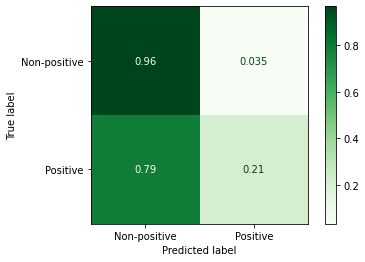

In [69]:
# Multinomial Naive Bayes

# create pipeline
pipeline_nb = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', MultinomialNB())
])
print('Naive Bayes')
# create model from pipeline and display results
model_results(pipeline_nb)

In [70]:
param_grid = {'clf__alpha': [0.001, 0.01, 0.1, 1]}
gridsearch = GridSearchCV(pipeline_nb, param_grid=param_grid, 
                              scoring='accuracy')

gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'clf__alpha': 0.1}

Naive Bayes
Training Score: 0.8899     
Test Score:     0.7218


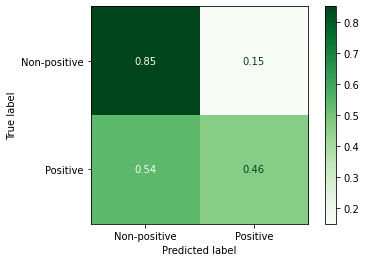

In [71]:
# Tuned Multinomial Naive Bayes

# create pipeline
pipeline_nb = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', MultinomialNB(alpha=0.1))
])
print('Naive Bayes')
# create model from pipeline and display results
model_results(pipeline_nb)

## Naive Bayes with oversampling

Naive Bayes with oversampling
Training Score: 0.8665     
Test Score:     0.6799


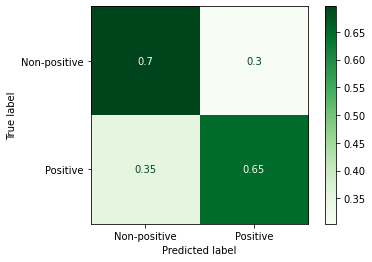

In [72]:
# Multinomial Naive Bayes with oversampling

# create pipeline
pipeline_nb_os = imblearn.pipeline.Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set oversampler
    ('os', RandomOverSampler(random_state=SEED)),
    # set classifier
    ('clf', MultinomialNB(alpha=0.1))
])
print('Naive Bayes with oversampling')
# create model from pipeline and display results
model_results(pipeline_nb_os)

## Logistic Regression

Logistic Regression
Training Score: 0.9593     
Test Score:     0.6259


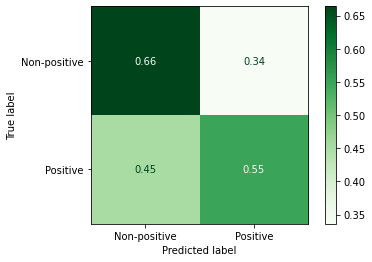

In [67]:
# logistic regression

# create pipeline
pipeline_lr = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=SEED))
])
print('Logistic Regression')
# create model from pipeline and display results
model_results(pipeline_lr)

## logistic regression with oversampling

Logistic Regression
Training Score: 0.9577     
Test Score:     0.6165


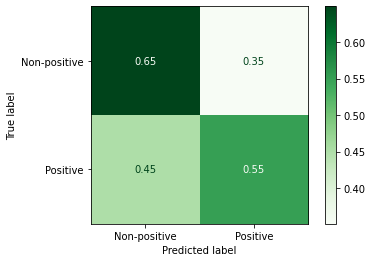

In [68]:
# logistic regression with oversampling

# create pipeline
pipeline_lr_os = imblearn.pipeline.Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set oversampler
    ('os', RandomOverSampler(random_state=SEED)),
    # set classifier
    ('clf', LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=SEED))
])
print('Logistic Regression')
# create model from pipeline and display results
model_results(pipeline_lr_os)

## decision tree

Decision Tree
Training Score: 0.9653     
Test Score:     0.7047


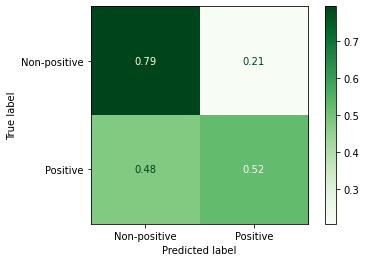

In [73]:
# decision tree

# create pipeline
pipeline_dt = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', DecisionTreeClassifier(random_state=SEED))
])
print('Decision Tree')
# create model from pipeline and display results
model_results(pipeline_dt)

In [74]:
param_grid = {'clf__criterion': ['gini', 'entropy'], 
        'clf__max_depth': [10, 20, None],
        'clf__min_samples_leaf': [1, 2, 3]
       }

gridsearch = GridSearchCV(estimator=pipeline_dt, param_grid = param_grid, scoring='accuracy')

gridsearch.fit(X_train,  y_train)
gridsearch.best_params_

{'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1}

Decision Tree
Training Score: 0.7926     
Test Score:     0.7157


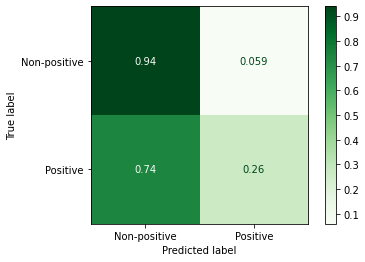

In [75]:
# tuned decision tree

# create pipeline
pipeline_dt = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', DecisionTreeClassifier(
        criterion='gini',
        max_depth=20,
        min_samples_leaf=1,
        random_state=SEED))
])
print('Decision Tree')
# create model from pipeline and display results
model_results(pipeline_dt)

## bagged trees

Bagged Trees
Training Score: 0.7472     
Test Score:     0.7174


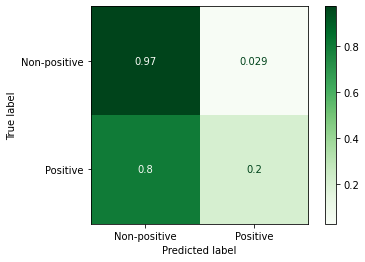

In [76]:
# bagged trees

# create pipeline
pipeline_bag = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', BaggingClassifier(
    DecisionTreeClassifier(criterion='entropy', max_depth=10), n_estimators=20, random_state=SEED))
])
print('Bagged Trees')
# create model from pipeline and display results
model_results(pipeline_bag)

## random forest

Random Forest
Training Score: 0.9653     
Test Score:     0.7317


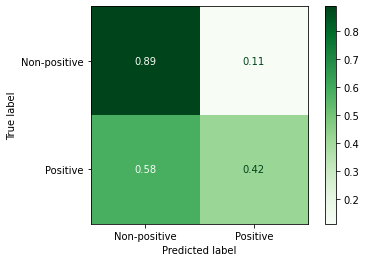

In [77]:
# random forest

# create pipeline
pipeline_rf = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', RandomForestClassifier(random_state=SEED))
])
print('Random Forest')
# create model from pipeline and display results
model_results(pipeline_rf)

In [78]:
param_grid = {'clf__criterion': ['gini', 'entropy'], 
        'clf__max_depth': [10, 20, None],
        'clf__min_samples_leaf': [1, 2, 3]
       }

gridsearch = GridSearchCV(estimator=pipeline_rf, param_grid = param_grid, scoring='accuracy')

gridsearch.fit(X_train,  y_train)
gridsearch.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': None,
 'clf__min_samples_leaf': 2}

Random Forest
Training Score: 0.864     
Test Score:     0.7245


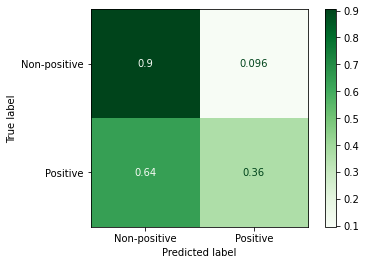

In [79]:
# tuned random forest

# create pipeline
pipeline_rf = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', RandomForestClassifier(criterion='entropy',
                                   max_depth=None,
                                   min_samples_leaf=2,
                                   random_state=SEED))
])
print('Random Forest')
# create model from pipeline and display results
model_results(pipeline_rf)

## support vector machine

Support Vector Machine
Training Score: 0.926     
Test Score:     0.7433


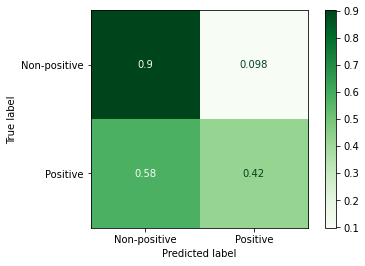

In [80]:
# support vector machine

# create pipeline
pipeline_svm = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', SVC(random_state=SEED))
])
print('Support Vector Machine')
# create model from pipeline and display results
model_results(pipeline_svm)

## adaboost

AdaBoost
Training Score: 0.7408     
Test Score:     0.7063


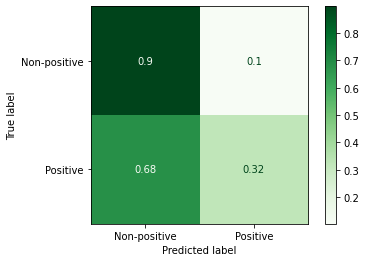

In [81]:
# adaboost

# create pipeline
pipeline_ab = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', AdaBoostClassifier(random_state=SEED))
])
print('AdaBoost')
# create model from pipeline and display results
model_results(pipeline_ab)

## gradient boost

Gradient Boost
Training Score: 0.7494     
Test Score:     0.7229


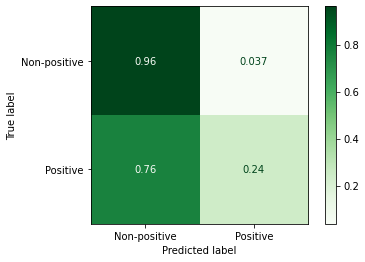

In [82]:
# gradient boost

# create pipeline
pipeline_gb = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', GradientBoostingClassifier(random_state=SEED))
])
print('Gradient Boost')
# create model from pipeline and display results
model_results(pipeline_gb)

Gradient Boost
Training Score: 0.8408     
Test Score:     0.7328


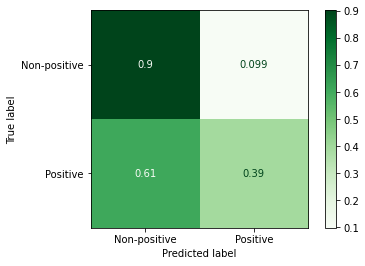

In [83]:
# XGB

# create pipeline
pipeline_xgb = Pipeline([
    # set vectorizer
    ('vectorizer', TfidfVectorizer(
        tokenizer = custom_tokenize,
        stop_words = stop_list
    )),
    # set classifier
    ('clf', XGBClassifier(random_state=SEED))
])
print('Gradient Boost')
# create model from pipeline and display results
model_results(pipeline_xgb)

In [96]:
tfidf = TfidfVectorizer(
    tokenizer = custom_tokenize,
    stop_words = stop_list
)

X_train_vectorized = tfidf.fit_transform(X_train)
# create the word list from this vectorizer with new index
feature_names = np.array(tfidf.get_feature_names())

# create array of the indices of the feature_names array, ordered by tfidf score
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

In [94]:
X_train_tokenized = X_train.apply(tokenizer.tokenize)

# create frequency distribution (dictionary) of 1-grams
all_words_freq_dist = FreqDist(X_train_tokenized.explode())

In [97]:
# show the words with the top 10 tfidf values, and their tfidf values
print('10 most useful words', '\n\ntfidf | frequency | word\n')
for n in range(-1,-11,-1):
    index = sorted_tfidf_index[n]
    print(
        round(X_train_vectorized.max(0).toarray()[0][index],4),
        all_words_freq_dist[feature_names[index]],
        feature_names[index]
         )
# show the words with the bottom 5 tfidf values, and their tfidf values
print('\n5 least useful words', '\n\ntfidf | frequency | word\n')
for n in range(5):
    index = sorted_tfidf_index[n]
    print(
        round(X_train_vectorized.max(0).toarray()[0][index],4),
        all_words_freq_dist[feature_names[index]],
        feature_names[index]
         )      

10 most useful words 

tfidf | frequency | word

1.0 1 worship
1.0 36 watch
0.9615 83 location
0.9594 3 hmmmm
0.9324 16 charging
0.9304 17 haha
0.9304 9 spot
0.928 35 texas
0.9195 28 everywhere
0.919 2 soo

5 least useful words 

tfidf | frequency | word

0.1996 1 twtng
0.1996 1 contxt
0.211 0 cu
0.211 0 ei
0.211 0 _a


In [ ]:
max_df_vals = np.linspace(1/100, 1, 100)
max_df_scores = []
for max_df in max_df_vals:
    tfidf = TfidfVectorizer(
        max_df = max_df
    )

    X_train_vectorized = tfidf.fit_transform(X_train['text'])

    max_df_scores.append(round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4))


In [ ]:
plt.scatter(max_df_vals, max_df_scores)
plt.ticklabel_format(axis='both', style='plain')

In [ ]:
tfidf = TfidfVectorizer(
    tokenizer = stem_and_lemmatize_and_tokenize,
    min_df = 2,
    max_df = .02
)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

stemmed_and_lemmatized_words_cv = round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4)

print('Plurality:                   ', plurality_cv,
      '\nStemmed and Lemmatized Words:', stemmed_and_lemmatized_words_cv
     )

# ITEMS TO ADD:

- tune the models
- features like length of tweet or number of words in tweet